In [178]:
import copy
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io

import warnings; warnings.simplefilter('ignore')

from mpl_toolkits.mplot3d import Axes3D
from nilearn import datasets, plotting
from sklearn.covariance import GraphLassoCV
from sklearn.decomposition import PCA

# Utilities

In [179]:
# Coordinates derived from brainGraph R package
def desikan_atlas_coordinates():
    desikan_x_coords = [-56,-2,-45,-1,-16,-24,-47,-56,-1,-43,-35.98,-3,-4,-68,-18,-3,-57,-44,-50,-12,-50,-1,-44,-9,-2,-34,-21,-25,-63,-60,-9,-26,-49,-41,50,3,43,3,21,33,48,61,1,38,20,5,7,69,20,4,57,49,55,14,51,1,47,7,4,43,16,17,67,65,9,37,45,43]
    desikan_y_coords = [-44,21,18,-82,-10,-54,-70,-32,-48,-87,30.71,-73,44,-29,-30,-28,22,48,35,-89,-26,-18,-12,-59,39,53,38,-62,-7,-41,65,15,-23,13,-42,21,14,-81,-4,-52,-67,-31,-48,-88,38,-69,45,-24,-29,-25,15,40,31,-85,-23,-16,-9,-57,38,45,34,-65,-12,-36,64,21,-25,12]
    desikan_z_coords = [5,27,46,20,-29,-16,31,-24,25,1,-12.11,-1,-14,-13,-18,62,18,-13,3,3,58,38,59,46,6,17,50,63,-1,39,-12,-35,9,-6,6,27,43,19,-32,-19,29,-27,26,1,-21,-1,-13,-14,-17,61,17,-13,5,5,56,37,54,41,4,21,53,59,-1,35,-13,-38,11,-6]
    desikan_coordinates = np.vstack((desikan_x_coords, desikan_y_coords, desikan_z_coords)).T
    return desikan_coordinates

In [180]:
def load_fmri_timeseries(subject_id, trial_id, atlas='desikan'):
    '''
    Returns a 2D matrix with dimensions (Channels, Time) of the fMRI timeseries for the provided subject and trial.
    '''
    path = 'data/fmri/'+atlas+'_atlas/'+subject_id+'/repos'+str(trial_id)+'_timeseries_regr_wgm_globmean_filt0009008.mat'
    if os.path.isfile(path):
        return scipy.io.loadmat(path)['timeseries']
    else:
        return None

In [181]:
def compute_fmri_connectomes(subject_id, trial_id, seconds_used_to_compute_connectome, atlas='desikan'):
    '''
    Returns a 3D matrix with dimensions (Time, ConnectivityAxis1, ConnectivityAxis2) of the
    fMRI connectomes for the provided subject, trial, and seconds_per_connectome.
    '''
    assert(seconds_used_to_compute_connectome >= 2)
    
    # Load raw fMRI timeseries
    fmri_timeseries = load_fmri_timeseries(subject_id, trial_id, atlas=atlas)
    if fmri_timeseries is None:
        return
    
    # Filter to only cortical fMRI data
    cortical_fmri_timeseries = fmri_timeseries[18:]
    
    # Compute connectomes
    # Note: 2 seconds of data are represented by each fMRI volume
    num_timepoints_per_connectome = int(seconds_used_to_compute_connectome/2) 
    fmri_connectome_matrices_through_time = []

    for t in range(num_timepoints_per_connectome, cortical_fmri_timeseries.shape[1]):
        cortical_fmri_timeseries_window = cortical_fmri_timeseries[:, t-num_timepoints_per_connectome:t]
        matrix = np.corrcoef(cortical_fmri_timeseries_window)
        fmri_connectome_matrices_through_time.append(matrix)
        
    return np.array(fmri_connectome_matrices_through_time)

In [182]:
def load_eeg_connectome(subject_id, trial_id, frequency_band, atlas='desikan'):
    '''
    Connectivity matrices are computed in the same step as source localization using the imaginary coherence measure.
    The time windows are non-overlapping 2 second windows corresponding to the time window of each concurrent fMRI volume.
    Therefore, we have 300 time windows with one connectivity matrix for each window per EEG oscillation band. 

    NOTE: The combined eeg connectomes returned from this method do not necessarily line up with the 
    fmri timeseries data returned from load_combined_fmri_timeseries.

    Returns a 3D matrix with dimensions (Time, ConnectivityAxis1, ConnectivityAxis2) for all eeg subject trials concatenated along the time dimension.
    '''
    
    path = 'data/eeg/'+atlas+'_atlas/'+subject_id+'/repos'+str(trial_id)+'/conn_desi_cohi_time_eeg_'+frequency_band+'_'+subject_id+'_repos'+str(trial_id)+'.mat'
    if os.path.isfile(path):
        data = scipy.io.loadmat(path)['connEEG'+frequency_band]
        data = np.moveaxis(data, 2, 0) # Move time axis to be the first axis
        return data
    else:
        return None

In [183]:
def load_artifact_timepoints(subject_id, trial_id, include_bad_fmri_frames=True):
    '''
    Returns the volume/window time indexes for EEG timepoints with artifacts. 
    Artifacts are determined with semi-automatic techniques and subsequent
    careful visual evaluation of the EEG data.
    
    If include_bad_fmri_frames is True, load_artifact_timepoints returns the 
    volume/window time indexes for EEG timepoints with artifacts UNIONED with 
    the set of timepoints with fMRI frame wise displacement.
    
    Note that a conservative threshold is used when computing fMRI frame wise displacement,
    resulting in a LOT of loss for some subjects.
    '''
    if include_bad_fmri_frames:
        path = 'data/head_motion/brainstorm_rejected_EEGandFD26.mat'
        artifact_timepoints_data = scipy.io.loadmat(path)['rejected_eeg'][0][0][0][0]
    else:
        path = 'data/head_motion/brainstorm_rejected26.mat'
        artifact_timepoints_data = scipy.io.loadmat(path)['subject'][0]

    
    for subject_data in artifact_timepoints_data:
        
        subject = subject_data[0][0]
        if subject != subject_id:
            continue
        
        for trial_data in subject_data[1][0]:
            
            trial = trial_data[0][0]
            if trial != 'repos'+str(trial_id):
                continue
            
            return trial_data[3][0]
    
    return []

In [184]:
def load_all_connectome_types(subject_id, trial_id, 
                             atlas='desikan', 
                             seconds_used_to_compute_fmri_connectome=60,
                             filter_artifact_timepoints=True,
                             exclude_bad_fmri_frames=True):
    '''
    Loads all fMRI and EEG connectomes for the specified subject and trial id. 
    Removes EEG connectomes that do not have an fMRI connectome correspondence.
    Removes artifact timepoints if specified.
    '''

    # Attempt to load both fmri and eeg connectomes
    fmri_connectomes = compute_fmri_connectomes(subject_id, trial_id, seconds_used_to_compute_fmri_connectome, atlas=atlas)
    alpha_eeg_connectomes  = load_eeg_connectome(subject_id, trial_id, frequency_band='alpha', atlas=atlas)
    beta_eeg_connectomes   = load_eeg_connectome(subject_id, trial_id, frequency_band='beta', atlas=atlas)
    delta_eeg_connectomes  = load_eeg_connectome(subject_id, trial_id, frequency_band='delta', atlas=atlas)
    gamma_eeg_connectomes  = load_eeg_connectome(subject_id, trial_id, frequency_band='gamma', atlas=atlas)
    theta_eeg_connectomes  = load_eeg_connectome(subject_id, trial_id, frequency_band='theta', atlas=atlas)
    
    if fmri_connectomes is None or alpha_eeg_connectomes is None or beta_eeg_connectomes is None or delta_eeg_connectomes is None or gamma_eeg_connectomes is None or theta_eeg_connectomes is None:
        return None
    
    # Note that there are less fmri connectomes than EEG connectomes because some number of frames are used to 
    # compute the initial fmri connectome. Here all EEG connectomes that do not have a corresponding fmri
    # connectome are dropped:
    num_dropped_frames = alpha_eeg_connectomes.shape[0] - fmri_connectomes.shape[0]
    
    alpha_eeg_connectomes = alpha_eeg_connectomes[num_dropped_frames:]
    beta_eeg_connectomes = beta_eeg_connectomes[num_dropped_frames:]
    delta_eeg_connectomes = delta_eeg_connectomes[num_dropped_frames:]
    gamma_eeg_connectomes = gamma_eeg_connectomes[num_dropped_frames:]
    theta_eeg_connectomes = theta_eeg_connectomes[num_dropped_frames:]
            
    # Load artifact timepoint labels if necessary
    if filter_artifact_timepoints:
        
        artifact_timepoints = load_artifact_timepoints(subject_id, trial_id, 
                                                       include_bad_fmri_frames=exclude_bad_fmri_frames)
        if artifact_timepoints is None:
            return None
        
        # Filter any artifact timepoints that were already dropped
        artifact_timepoints = list(filter(lambda a: a >= num_dropped_frames, artifact_timepoints))
        
        # Shift artifact timepoints to start at 0
        artifact_timepoints = [at - num_dropped_frames for at in artifact_timepoints]
            
        # Drop all 'bad' connectomes
        fmri_connectomes = np.delete(fmri_connectomes, artifact_timepoints, axis=0)
        alpha_eeg_connectomes = np.delete(alpha_eeg_connectomes, artifact_timepoints, axis=0)
        beta_eeg_connectomes = np.delete(beta_eeg_connectomes, artifact_timepoints, axis=0)
        delta_eeg_connectomes = np.delete(delta_eeg_connectomes, artifact_timepoints, axis=0)
        gamma_eeg_connectomes = np.delete(gamma_eeg_connectomes, artifact_timepoints, axis=0)
        theta_eeg_connectomes = np.delete(theta_eeg_connectomes, artifact_timepoints, axis=0)
    
    return {
        'fmri':fmri_connectomes,
        'alpha':alpha_eeg_connectomes,
        'beta':beta_eeg_connectomes,
        'delta':delta_eeg_connectomes,
        'gamma':gamma_eeg_connectomes,
        'theta':theta_eeg_connectomes,
    }

In [185]:
ALL_SUBJECT_IDS = set([pth.split('/')[-1] for pth in glob.glob('data/**/**/*')])
ALL_TRIAL_IDS = range(1, 4)

In [186]:
def load_connectomes(subject_ids, trial_ids,
                     atlas='desikan', 
                     seconds_used_to_compute_fmri_connectome=60,
                     filter_artifact_timepoints=True,
                     exclude_bad_fmri_frames=True):
    '''
    Loads all connectome types for all specified subject/trial ids and
    concatenates them in the time dimension.
    '''
    
    # Gather connectomes for all specified subjects and trials
    all_subjects_all_trials_connectomes = []

    for subject_id in subject_ids:
        for trial_id in trial_ids:
            connectomes = load_all_connectome_types(subject_id, trial_id,
                                                   atlas=atlas, 
                                                   seconds_used_to_compute_fmri_connectome=seconds_used_to_compute_fmri_connectome,
                                                   filter_artifact_timepoints=filter_artifact_timepoints,
                                                   exclude_bad_fmri_frames=exclude_bad_fmri_frames)
            if connectomes is not None:
                all_subjects_all_trials_connectomes.append(connectomes)
            
    # Smush separate connectomes into one mega time series
    all_subjects_all_trials_connectomes_smushed = all_subjects_all_trials_connectomes[0]
    for i in range(1, len(all_subjects_all_trials_connectomes)):
        connectomes = all_subjects_all_trials_connectomes[i]
        for k in connectomes:
            all_subjects_all_trials_connectomes_smushed[k] = np.concatenate([all_subjects_all_trials_connectomes_smushed[k], connectomes[k]], axis=0)
        
    return all_subjects_all_trials_connectomes_smushed

# Low Dimensional Connectome Dynamics

In [187]:
all_subjects_all_trials_connectomes = load_connectomes(ALL_SUBJECT_IDS, ALL_TRIAL_IDS)
all_subjects_all_trials_connectomes['fmri'].shape

(17906, 68, 68)

#### Principal Component Analysis

Extract flattened representation of upper triangular of Pearson correlation matrix for each connectome type.

In [188]:
# NOTE: The below logic would have to change if we move away from using Desikan Atlas where the number of regions 
# are the same between EEG and fMRI
num_regions = all_subjects_all_trials_connectomes['fmri'].shape[1]
num_regions

68

In [189]:
upper_triangular_including_diagonal_idxs = np.triu_indices(num_regions, k=0)
lower_triangular_idxs = np.tril_indices(num_regions, k=-1)

In [190]:
all_subjects_all_trials_connectome_upper_triangular_flattened = copy.deepcopy(all_subjects_all_trials_connectomes)
for k in all_subjects_all_trials_connectome_upper_triangular_flattened:
    all_subjects_all_trials_connectome_upper_triangular_flattened[k] = np.array([c[upper_triangular_including_diagonal_idxs].flatten() for c in all_subjects_all_trials_connectomes[k]])

In [191]:
all_subjects_all_trials_connectome_upper_triangular_flattened['fmri'].shape

(17906, 2346)

Compute principal components of every connectome time series individually.

In [192]:
n_components = 10
pca_models = [PCA(n_components=n_components).fit(all_subjects_all_trials_connectome_upper_triangular_flattened[k]) for k in all_subjects_all_trials_connectome_upper_triangular_flattened]

Plot variance explained ratio for each connectome type.

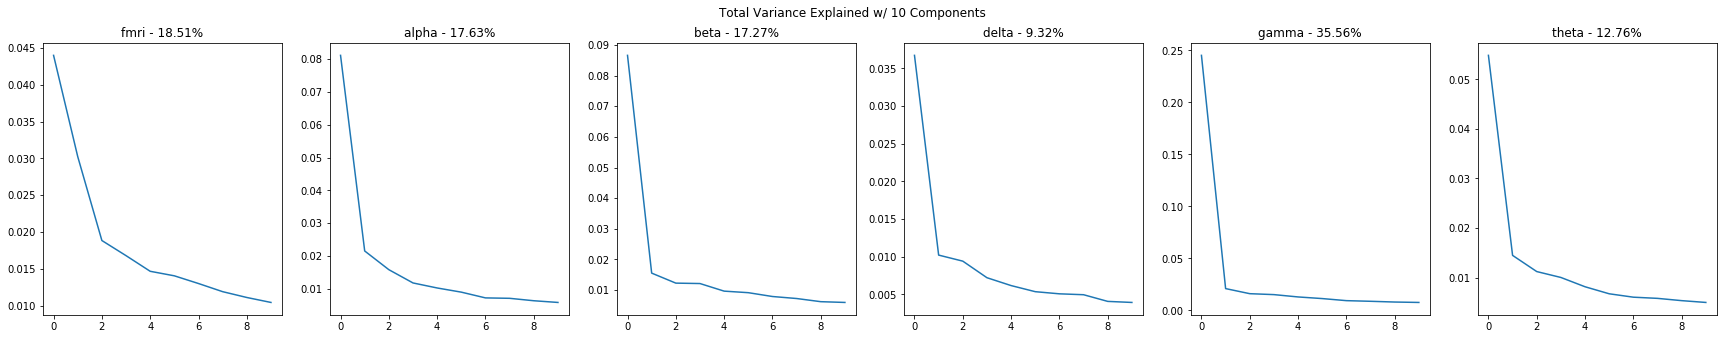

In [194]:
fig = plt.figure(figsize=(30, 5))
fig.suptitle('Total Variance Explained w/ ' + str(n_components) + ' Components')

subplot_idx = 1
for (k, pca_model) in zip(all_subjects_all_trials_connectome_upper_triangular_flattened, pca_models):
    fig.add_subplot(1, len(pca_models), subplot_idx)
    plt.plot(pca_model.explained_variance_ratio_)
    plt.title("{0} - {1:.2f}%".format(k, 100*sum(pca_model.explained_variance_ratio_)))
    subplot_idx += 1    

plt.show(fig)

Plot spatial representation of each principal component in connectome space.

In [195]:
pca_models[0].components_.shape

(10, 2346)

In [197]:
fig = plt.figure(figsize=(180, 60))
fig.suptitle('Spatial Loadings of Principal Components', fontsize=40)

subplot_idx = 1
for (k, pca_model) in zip(all_subjects_all_trials_connectome_upper_triangular_flattened, pca_models):
    for component_idx in range(0, n_components):
        
        # Extract connectome representation of the principal component
        pc = np.zeros((num_regions, num_regions))
        pc[upper_triangular_including_diagonal_idxs] = pca_model.components_[component_idx]
        pc[lower_triangular_idxs] = pc.T[lower_triangular_idxs]

        # Plot connectome representation of the principal component
        ax = fig.add_subplot(len(pca_models), n_components, subplot_idx)
        plotting.plot_connectome(pc, desikan_atlas_coordinates(), title='{0} PC{1} Connectome'.format(k, component_idx+1),
                                 edge_threshold='95%', node_size=20, colorbar=True, axes=ax)
        subplot_idx += 1

plt.savefig('output/principal_component_analysis/spatial_loadings.png')

Plot correlation of principal component with connectome through time.

In [198]:
fig = plt.figure(figsize=(300, 300))
fig.suptitle('Low-Dimensional Manifold Traversed by Brain State', fontsize=60)

subplot_idx = 1
for (k, pca_model) in zip(all_subjects_all_trials_connectome_upper_triangular_flattened, pca_models):
    
    correlation_timeseries_for_first_three_pcs = []
    
    # Gather correlation timeseries for the first 3 principal components
    for component_idx in range(0, 3):
        
        # Compute correlation between pc and connectome timeseries
        pc = pca_model.components_[component_idx]
        connectome_timeseries = all_subjects_all_trials_connectome_upper_triangular_flattened[k]
        
        correlation_between_pc_and_connectome_timeseries = [np.corrcoef(pc, time_pt)[0, 1] for time_pt in connectome_timeseries]
        correlation_timeseries_for_first_three_pcs.append(correlation_between_pc_and_connectome_timeseries)
        
    # Plot correlation timeseries for first 3 PCs in a 3d scatterplot
    ax = fig.add_subplot(len(pca_models), 4, subplot_idx, projection='3d')
    ax.plot(correlation_timeseries_for_first_three_pcs[0],
            correlation_timeseries_for_first_three_pcs[1],
            correlation_timeseries_for_first_three_pcs[2],
            c='black',
            alpha=0.2,
            linewidth=0.5)
    ax.scatter(correlation_timeseries_for_first_three_pcs[0],
               correlation_timeseries_for_first_three_pcs[1],
               correlation_timeseries_for_first_three_pcs[2],
               c=np.arange(len(correlation_timeseries_for_first_three_pcs[0])), 
               alpha=0.5,
               cmap='YlGnBu',
               marker='o')
    ax.set_xlabel('PC1', fontsize=20)
    ax.set_ylabel('PC2', fontsize=20)
    ax.set_zlabel('PC3', fontsize=20)
    ax.set_title(k, fontsize=30)
    subplot_idx += 1
    
    # Plot correlation timeseries for each PC separately
    ax = fig.add_subplot(len(pca_models), 4, subplot_idx)
    ax.plot(correlation_timeseries_for_first_three_pcs[0])
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('PC1 Correlation', fontsize=20)
    ax.set_title("{0} PC1".format(k), fontsize=30)
    subplot_idx += 1
    
    ax = fig.add_subplot(len(pca_models), 4, subplot_idx)
    ax.plot(correlation_timeseries_for_first_three_pcs[1])
    ax.set_xlabel('Time', fontsize=20)    
    ax.set_ylabel('PC2 Correlation', fontsize=20)
    ax.set_title("{0} PC2".format(k), fontsize=30)
    subplot_idx += 1
    
    ax = fig.add_subplot(len(pca_models), 4, subplot_idx)
    ax.plot(correlation_timeseries_for_first_three_pcs[1])
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('PC3 Correlation', fontsize=20)
    ax.set_title("{0} PC3".format(k), fontsize=30)
    subplot_idx += 1

plt.savefig('output/principal_component_analysis/low_dimensional_manifold_traversal.png')

# Visualize fMRI/EEG Connectome Dynamics

In [ ]:
for subject_id in all_subject_ids:
    for trial_id in all_trial_ids:
        
        # Attempt to load all connectome types
        connectomes = load_all_connectome_types(subject_id, trial_id,
                                               atlas='desikan', 
                                               seconds_used_to_compute_fmri_connectome=60,
                                               exclude_bad_fmri_frames=True,
                                               filter_artifact_timepoints=True)
        
        if connectomes is None:
            continue

        # Plot connectomes through time
        for t in range(0, connectomes['fmri'].shape[0]):
            
            # Create figure and set title
            fig = plt.figure(figsize=(30, 35))
            fig.suptitle('Subject: "{0}" | Trial: {1} | Time: {2}'.format(subject_id, trial_id, t), fontsize=50)
            
            # Plot connectomes
            subplot_idx = 1
            for connectome_id, connectome in connectomes.items():

                ax = fig.add_subplot(len(connectomes), 2, subplot_idx)
                plotting.plot_connectome(connectome[t], desikan_atlas_coordinates(), title='{0} Connectome'.format(connectome_id),
                                         edge_threshold='95%', node_size=20, colorbar=True, axes=ax)
                subplot_idx += 1
            
                ax = fig.add_subplot(len(connectomes), 2, subplot_idx)
                plotting.plot_matrix(connectome[t], vmin=-1., vmax=1., colorbar=True, axes=ax)
                subplot_idx += 1
    
            plt.savefig('output/connectomes_through_time/subject={0}_trial={1}_t={2}.png'.format(subject_id, trial_id, t))
        break